In this document, we will implement a well-known customer segmentation technique known as the RFM model on the provided sales data.

* This model measures 3 factors for the customers where:

  * **Recency (R)**: Measures how recently the customer made a purchase, more recent buyers are typically more likely to engage again
  * **Frequency (F)**: Evaluates how often a customer makes purchases, higher frequency indicates greater loyalty
  * **Monetary Value (M)**: Assesses how much money a customer spends, customers who spend more are valuable to the business

* The sales data encompasses transactions from 01-Jan-2015 to 30-Dec-2018 and we will treat the date 31-Dec-2018 as our snapshot date (the day following the last transaction)
* Our analysis will focus solely on the most recent 18 months of data

In [395]:
# load CSV data to DateFrame
import pandas as pd
import numpy as np

sales_df = pd.read_csv('data.csv')
sales_df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [396]:
# Converting Order Date column to date
sales_df['Order Date'] = pd.to_datetime(sales_df['Order Date'], dayfirst=True)

In [397]:
# Snapshot date (The hypothetical "Today")
from datetime import datetime, timedelta

last_transaction_date = sales_df["Order Date"].max()
snapshot_date = last_transaction_date + timedelta(days=1)
print('Last Transaction Date :', last_transaction_date)
print('Snapshot Date :', snapshot_date)

Last Transaction Date : 2018-12-30 00:00:00
Snapshot Date : 2018-12-31 00:00:00


In [398]:
# Subset of trailing 18 months sales 
sales_last_18_months = sales_df[sales_df["Order Date"] >= datetime(2018, 12, 30) - timedelta(days=540)]

In [399]:
# Aggregating orders' lines
orders_last_18_months = sales_last_18_months.groupby(['Customer ID','Order ID', 'Order Date'])['Sales'].sum().reset_index()

In [400]:
# Now we populate recency, frequency and monetary columns for each column where
# All of the above are for the last 18 months assuming today's date is 2018-12-31
# We will assign the result to a DataFrame called 'datamart' 

datamart = orders_last_18_months.groupby("Customer ID").agg(
    recency=("Order Date", lambda x: (snapshot_date - x.max()).days),  # days passed since the last order
    frequency=("Order ID", "count"),                                   # number of orders during the period
    monetary=("Sales", "sum"),                                         # sales generated during the period
).reset_index()
datamart.head()

,Customer ID,recency,frequency,monetary
0,AA-10315,185,1,374.480
1,AA-10375,20,4,737.020
2,AA-10480,260,3,1763.052
3,AA-10645,56,2,304.700
4,AB-10015,416,1,563.940


In [401]:
# converting the above table into an Array type to use it in further steps
samples = datamart[['recency','frequency','monetary']].values

In [402]:
# In this step, we are utilizing the KMeans algorithm to cluster the customers based on their RFM metrics. 
# By segmenting customers into distinct groups, we can gain valuable insights into their purchasing behavior and preferences.

# The KMeans algorithm is particularly effective for this task as it identifies patterns within the data, 
# allowing us to categorize customers based on similarities in their RFM metrics
# this will generate 3 cluster numbers which we will use for further analysis in the next steps

from sklearn.cluster import KMeans

km = KMeans(n_clusters=3, random_state=1)
km.fit(samples)

KMeans(n_clusters=3, random_state=1)

In [403]:
# adding the cluster numbers to the datamart, and showing the first 5 rows
datamart['cluster_num'] = km.labels_
datamart.head()

,Customer ID,recency,frequency,monetary,cluster_num
0,AA-10315,185,1,374.480,1
1,AA-10375,20,4,737.020,1
2,AA-10480,260,3,1763.052,0
3,AA-10645,56,2,304.700,1
4,AB-10015,416,1,563.940,1


In [404]:
# In this step I will give a color for each cluster number and add it to the datamart so we can refer to each cluster by its color
colors = {0:'purple',1:'red',2:'teal'}
datamart['cluster_color'] = datamart['cluster_num'].map(colors)
datamart.head()

,Customer ID,recency,frequency,monetary,cluster_num,cluster_color
0,AA-10315,185,1,374.480,1,red
1,AA-10375,20,4,737.020,1,red
2,AA-10480,260,3,1763.052,0,purple
3,AA-10645,56,2,304.700,1,red
4,AB-10015,416,1,563.940,1,red


In [405]:
# This is a summary table reporting averages of the 3 meterics by cluster in addition to customers count and total sales generated from each
customer_cluster_summary = (
    datamart.groupby(["cluster_color"]).agg(
        Mean_Recency=("recency", "mean"),
        Mean_Frequency=("frequency", "mean"),
        Mean_Monetary=("monetary", "mean"),
        Customer_Count=("Customer ID", "count"),
        Total_Sales=("monetary", "sum"),
    ).round(1)
).reset_index()
customer_cluster_summary

,cluster_color,Mean_Recency,Mean_Frequency,Mean_Monetary,Customer_Count,Total_Sales
0,purple,82.4,4.2,2698.8,189,510072.7
1,red,132.4,2.8,658.6,535,352368.5
2,teal,76.3,5.1,7695.8,29,223177.5


# Visualization

* The below chart presents the Recency on the x axis, Frequency on the y axis and the bubble size corresponds to Monetary.
* The two crossed blue lines illustrates the averages of the R & F

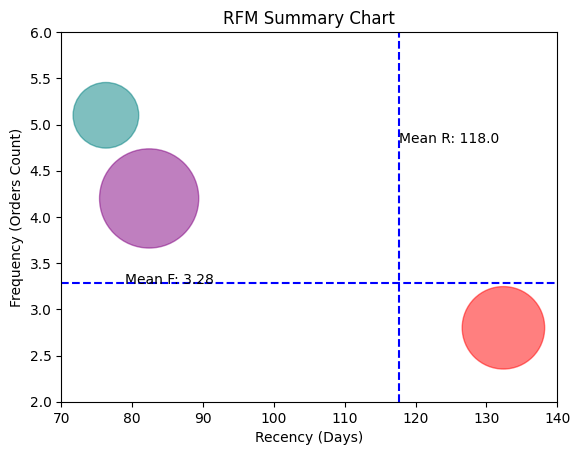

In [406]:
import matplotlib.pyplot as plt

r_line = datamart['recency'].mean()
f_line = datamart['frequency'].mean()
# plt.scatter(data=datamart, x='recency', y='frequency', c='cluster', s='monetary')
# plt.scatter(data=datamart, x='recency', y='frequency', c='cluster')
plt.scatter(
    # data=customer_cluster_summary,
    x=customer_cluster_summary["Mean_Recency"],
    y=customer_cluster_summary["Mean_Frequency"],
    s=customer_cluster_summary['Total_Sales'] / 100,
    c=colors.values(),
    alpha=0.5,
)
plt.title("RFM Summary Chart")
plt.axhline(y=f_line, linestyle="--", c='b', label="Mean F=" + str(f_line))
plt.axvline(x=r_line, linestyle="--", c='b', label="Mean R=" + str(r_line))
plt.text(x=79, y=f_line, s="Mean F: " + str(round(f_line, 2)))
plt.text(x=r_line, y=4.8, s="Mean R: " + str(round(r_line, 0)))
# plt.legend()
plt.xlim(70, 140)
plt.ylim(2, 6)
plt.xlabel("Recency (Days)")
plt.ylabel("Frequency (Orders Count)")
plt.show()

# Conclusion

  * The 'purple' cluster comprises customers who have a moderate recency score (82.4 days), indicating they made a purchase within the last three months. They have a decent purchase frequency and contribute significantly to total sales.
  * Customers in the red cluster have the highest recency score, suggesting they haven’t purchased in over four months. This group has the highest number of customers but the lowest frequency and monetary contributions. They may require re-engagement strategies such as promotions or personalized communication to encourage repeat purchases.
  * The 'teal' cluster represents a small but highly valuable group of customers. They have low recency, high frequency, and exceptionally high monetary values. This suggests that these customers are very engaged and contribute significantly to sales. Strategies to reward this group, such as loyalty programs, VIP experience or exclusive offers, could further enhance their value.

# Cohort Analysis

To evaluate customer behavior over a specific timeframe (in our case, 18 months), we will utilize cohort analysis, which is a technique that effectively highlights how different segments of customers engage over time.

To complete the cohort view task, we will extract the month of the first purchase, which we’ll refer to as the cohort month. We will then get the order month from the order date. By subtracting the order month from the cohort month, we can calculate the cohort index, showing how cohorts perform relative to their initial purchase month

In [407]:
# Adding Order Month column to the DataFrame
def trunc_date(pdate):
    return datetime(pdate.year, pdate.month, 1)

orders_last_18_months['Order Month'] = orders_last_18_months['Order Date'].apply(trunc_date)

In [408]:
# Adding Cohort Month column to the DataFrame
cohort_months = orders_last_18_months.groupby('Customer ID')['Order Month'].min().to_dict()
orders_last_18_months['Cohort_Month'] = orders_last_18_months['Customer ID'].map(cohort_months)

In [409]:
# Calculating Cohort Index column (in months) and adding it to the DataFrame
years = orders_last_18_months['Order Month'].dt.year - orders_last_18_months['Cohort_Month'].dt.year
months = orders_last_18_months['Order Month'].dt.month - orders_last_18_months['Cohort_Month'].dt.month
orders_last_18_months['Cohort Index'] = years * 12 + months + 1
# Formatting Cohort Month column "YYYY-MM"
orders_last_18_months['Cohort Month'] = orders_last_18_months['Cohort_Month'].dt.strftime('%Y-%m')

In [410]:
# Preparing cohort matrix
cohort_view = pd.crosstab(orders_last_18_months['Cohort Month'], orders_last_18_months['Cohort Index'])
cohort_view

Cohort Index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Cohort Month,,,,,,,,,,,,,,,,,,
2017-07,77,9,14,11,13,20,6,5,5,11,10,13,8,15,10,12,26,26
2017-08,80,19,7,16,16,2,6,10,17,12,22,9,9,21,18,29,22,0
2017-09,153,14,33,29,17,12,26,28,22,17,27,23,41,27,43,49,0,0
2017-10,71,19,18,7,5,8,6,8,13,6,9,17,11,23,13,0,0,0
2017-11,101,20,5,2,16,14,16,10,7,9,29,12,26,29,0,0,0,0
2017-12,69,4,3,10,10,16,8,10,9,25,13,17,22,0,0,0,0,0
2018-01,26,0,4,5,2,1,3,5,5,4,9,6,0,0,0,0,0,0
2018-02,19,2,2,1,3,3,2,9,3,7,2,0,0,0,0,0,0,0
2018-03,36,2,3,9,6,3,11,10,14,6,0,0,0,0,0,0,0,0


In [411]:
# By dividing each column by the first column (cohort size) we will get the retension ratio per cohort
cohort_size = cohort_view[1]
retention_ratios = cohort_view.divide(cohort_size, axis=0).round(2)
retention_ratios

Cohort Index,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Cohort Month,,,,,,,,,,,,,,,,,,
2017-07,1.0,0.12,0.18,0.14,0.17,0.26,0.08,0.06,0.06,0.14,0.13,0.17,0.10,0.19,0.13,0.16,0.34,0.34
2017-08,1.0,0.24,0.09,0.20,0.20,0.02,0.08,0.12,0.21,0.15,0.28,0.11,0.11,0.26,0.22,0.36,0.28,0.00
2017-09,1.0,0.09,0.22,0.19,0.11,0.08,0.17,0.18,0.14,0.11,0.18,0.15,0.27,0.18,0.28,0.32,0.00,0.00
2017-10,1.0,0.27,0.25,0.10,0.07,0.11,0.08,0.11,0.18,0.08,0.13,0.24,0.15,0.32,0.18,0.00,0.00,0.00
2017-11,1.0,0.20,0.05,0.02,0.16,0.14,0.16,0.10,0.07,0.09,0.29,0.12,0.26,0.29,0.00,0.00,0.00,0.00
2017-12,1.0,0.06,0.04,0.14,0.14,0.23,0.12,0.14,0.13,0.36,0.19,0.25,0.32,0.00,0.00,0.00,0.00,0.00
2018-01,1.0,0.00,0.15,0.19,0.08,0.04,0.12,0.19,0.19,0.15,0.35,0.23,0.00,0.00,0.00,0.00,0.00,0.00
2018-02,1.0,0.11,0.11,0.05,0.16,0.16,0.11,0.47,0.16,0.37,0.11,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2018-03,1.0,0.06,0.08,0.25,0.17,0.08,0.31,0.28,0.39,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


# Cohort Analysis visualization

Every Row presents a cohort, ratios are the retention rate for a particular cohort index
The darker the green the higher the rate!

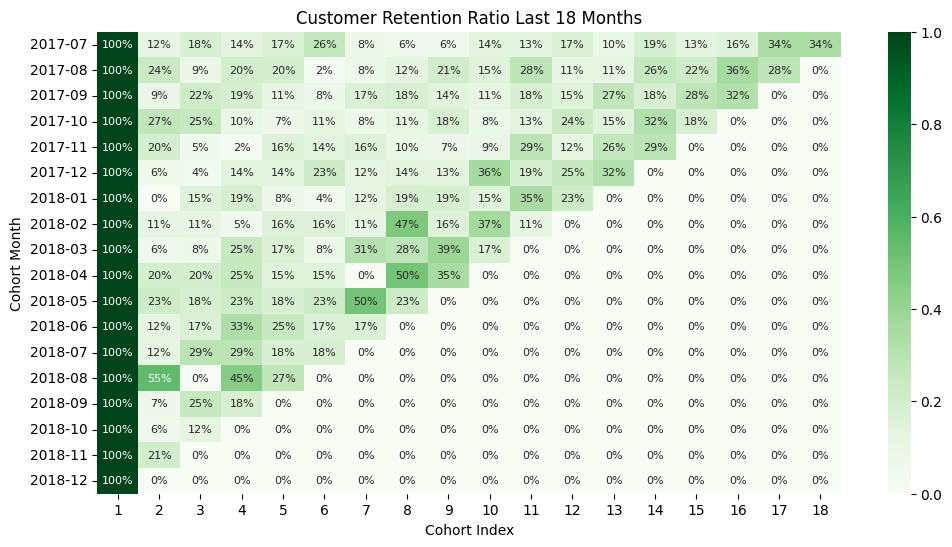

In [412]:
import seaborn as sns

plt.figure(figsize=(12, 6))
plt.title('Customer Retention Ratio Last 18 Months')
sns.heatmap(retention_ratios, annot=True, annot_kws={'size':8} ,fmt='0.0%', cmap='Greens')
plt.show()